# Downloads
In Colab download only once per session.

In [0]:
# Download Mask R-CNN
!git clone https://github.com/matterport/Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 119.72 MiB | 29.78 MiB/s, done.
Resolving deltas: 100% (549/549), done.


In [0]:
# Download Images
!wget http://clic.nlp.cornell.edu/resources/NLVR2/train_img.zip

In [0]:
!wget http://clic.nlp.cornell.edu/resources/NLVR2/dev_img.zip

In [0]:
!wget http://clic.nlp.cornell.edu/resources/NLVR2/test1_img.zip

In [0]:
# Unzip Files
!unzip -q train_img.zip

In [0]:
!unzip -q dev_img.zip

In [0]:
!unzip -q test1_img.zip

# Imports

In [0]:
import sys
import pandas as pd
import os, fnmatch
# from IPython.display import Image, display
from PIL import Image, ImageOps
import ipywidgets as w
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
from google.colab import files

# Keras provides utility functions to plot a Keras model using graphviz
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

# Import Mask RCNN
ROOT_DIR = os.path.abspath("/content/Mask_RCNN")
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

# Import COCO config
sys.path.append(os.path.join('/content/Mask_RCNN/samples/coco/'))  # To find local version
import coco

# Directory to save logs and trained model
MODEL_DIR = os.path.join('/content/Mask_RCNN/logs')

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join('/content/Mask_RCNN/mask_rcnn_coco.h5')

# Directory of images to run detection on
IMAGE_DIR = os.path.join('/content/images')

# Download COCO pretrained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

def find(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result

Using TensorFlow backend.


... done downloading pretrained model!


# Mask R-CNN

## Configuration

In [0]:
# config : __main__.InferenceConfig
class InferenceConfig(coco.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
# Set batch size to 1 since we'll be running inference on
# one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
config = InferenceConfig()

# Display configuration
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Model

In [0]:
# Create model object in inference mode.
# model : mrcnn.model.MaskRCNN
# Encapsulates the Mask RCNN model functionality
# The actual Keras model is in the keras_model property
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [0]:
# plot a Keras model
# obtain the pydot.Graph object
# render it in an ipython notebook
SVG(model_to_dot(model.keras_model).create(prog='dot', format='svg'))

In [0]:
# Save model to png
#plot_model(model.keras_model, to_file='model.png')

# Download Keras Model png
# Works only in Chrome
#files.download('model.png')

In [0]:
# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

In [0]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

# Load NLVR Dataset

In [0]:
# JSON NLVR Training data
!wget https://raw.githubusercontent.com/clic-lab/nlvr/master/nlvr2/data/train.json

--2019-04-06 08:51:04--  https://raw.githubusercontent.com/clic-lab/nlvr/master/nlvr2/data/train.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40735513 (39M) [text/plain]
Saving to: ‘train.json.1’

train.json.1        100%[===================>]  38.85M   210MB/s    in 0.2s    

2019-04-06 08:51:05 (210 MB/s) - ‘train.json.1’ saved [40735513/40735513]



In [0]:
# Datafreame Pandas
df = pd.read_json('train.json', lines=True)
identifier_df = df['identifier'].str.extract('(?P<set_id>\d{1,})-(?P<pair_id>\d)-(?P<sentence_id>\d)', expand=True)
df['set_id'] = identifier_df['set_id']
df['pair_id'] = identifier_df['pair_id']
df['sentence_id'] = identifier_df['sentence_id']

# Take one NLVR Sample

In [0]:
# Take one sample
sample = df.sample()

# sample_values : pandas.core.series.Series
sample_values = sample.iloc[0]
sample_set_id = sample_values['set_id']
sample_pair_id = sample_values['pair_id']
sample_sentence_id = sample_values['sentence_id']
sample_lookup = '*-' + sample_set_id + '-' + sample_pair_id + '*'

# Image Lookup
sample_path_0 = find(sample_lookup, 'images')[0]
sample_path_1 = find(sample_lookup, 'images')[1]
sample_sentence = sample['sentence'].iloc[0]
sample_label = sample['label'].iloc[0]

# img0, img1 : IPython.core.display.Image
img_0 = Image.open(sample_path_0)
img_1 = Image.open(sample_path_1)

# Resize like when displayed to the workers during sentence-writing
size = (530, 416)
img_res_0 = ImageOps.fit(img_0, size, Image.ANTIALIAS)
img_res_1 = ImageOps.fit(img_1, size, Image.ANTIALIAS)

images = [img_res_0, img_res_1]
widths, heights = zip(*(i.size for i in images))

total_width = sum(widths)
max_height = max(heights)

# pair_im : PIL.Image.Image
pair_im = Image.new('RGB', (total_width, max_height))

x_offset = 0
for im in images:
  pair_im.paste(im, (x_offset,0))
  x_offset += 1+im.size[0]
  
pair_im.save('pair_im.jpg')

# Run Model

An image shows at least one filled water bottle with a blue lid and no label.


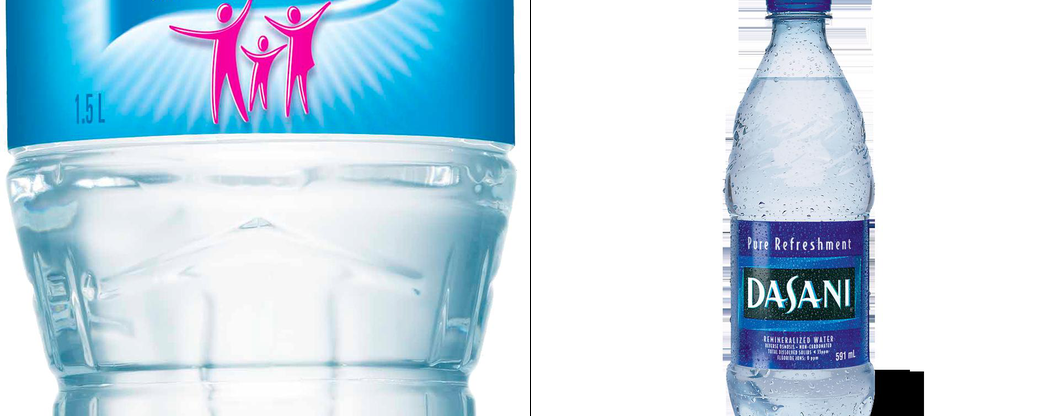

In [0]:
# Print sentence and image pair
print(sample_sentence)
pair_im

In [0]:
# Print label
print(sample_label)

False


In [0]:
image = skimage.io.imread('pair_im.jpg')

# Run detection
results = model.detect([image], verbose=1)

Processing 1 images
image                    shape: (416, 1060, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1060.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


In [0]:
r = results[0]

# y represents the number of occurrences
y = np.bincount(r['class_ids'])

# ii represents the class ids with non-zero occurrences
ii = np.nonzero(y)[0]

# z zips the mapping of ii to the class_names and
# the nuber of occurrences.
z = zip(np.take(class_names,ii),y[ii])

# List zip
list(z)

[('bottle', 1)]

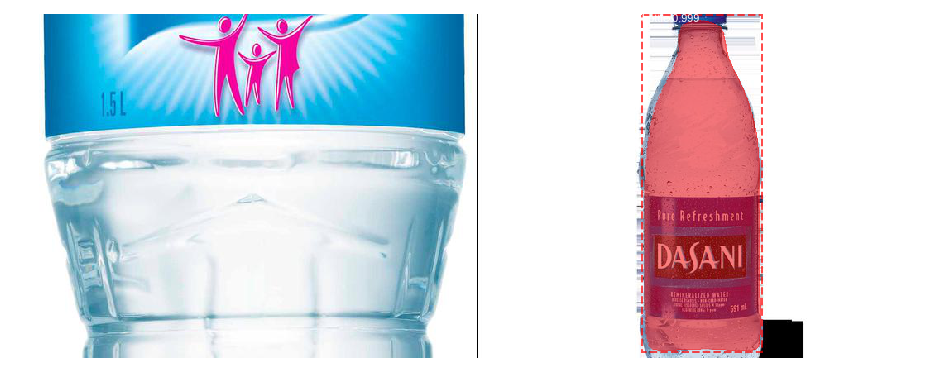

In [0]:
# Visualize results
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [48]:
# Debugging: print dataset row
sample

,directory,extra_validations,identifier,label,left_url,query,right_url,sentence,synset,validation,writer,set_id,pair_id,sentence_id
7153,39,NaN,train-7761-1-0,False,http://pngimg.com/uploads/water_bottle/water_b...,two water bottles5,http://pngimg.com/uploads/water_bottle/water_b...,An image shows at least one filled water bottl...,water bottle,{'127': 'False'},61,7761,1,0


In [0]:
# Debugging_ print images path
print(sample_path_0, sample_path_1)

images/train/6/train-8056-1-img1.png images/train/6/train-8056-1-img0.png


In [0]:
# Debugging URLs
sample_values['left_url']

'https://upload.wikimedia.org/wikipedia/commons/7/78/Group_of_young_pelicans_%285283040260%29.jpg'

In [0]:
# Debugging URLs
sample_values['right_url']

'https://galenleeds.files.wordpress.com/2011/09/mg_7041-wm.jpg'